# This notebook further optimize the simulation efficiency by vectorizing the measurement generation & gradient calc and update. Only ConsensusEKF is still performed via a subloop due to its stateful nature, where vectorization is difficult.

**Also, we only consider fixed-topology networks in the experiments below.**

In [158]:

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pickle as pkl
import networkx as nx
from matplotlib import style
from functools import partial

from utils.dLdp import analytic_dLdp,analytic_dhdz,analytic_dhdq,analytic_FIM
from utils.ConsensusEKF import ConsensusEKF

import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up F_tilde data structure

In [2]:
def circulant(i,q,p,prev,post,undirected=False):
    """
        Generate a circulant graph with len(p) nodes, node i connected with [i-prev:i+post],i-prev and i+post included but self-loop eliminated.
    """
    n = len(p)
    G = nx.DiGraph()
    edges = [(j%n,i) for i in range(n) for j in range(i-prev,i+post+1)]
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))
    if undirected:
        G = G.to_undirected()
    return G
    

In [6]:
def single_meas_func(C1,C0,k,b,dist):
    return k*(dist-C1)**b+C0

def joint_meas_func(C1s,C0s,ks,bs,x,ps):

    # Casting for the compatibility of jax.numpy

    C1=np.array(C1s)
    C0=np.array(C0s)
    k=np.array(ks)
    b=np.array(bs)
    p=np.array(ps)

    # Keep in mind that x is a vector of [q,q'], thus only the first half of components are observable.    
    dists=np.linalg.norm(x[:len(x)//2]-p,axis=1)

    return single_meas_func(C1,C0,k,b,dists) 

In [273]:
def main(N_trails,coordinate=False,version='v1'):
    '''Experiment Parameters'''
    N_sen = 6 # Number of sensors.

    q = np.array([6,6])
    p_0 = np.random.rand(N_sen,2)*3
    qhat_0 = np.random.rand(N_sen,2)*10


    comm_network_generator=lambda i,q,p:circulant(i,q,p,prev=1,post=0,undirected=True)

    N_iter=80
    C_gain=0.1

    # Set up virtual sensors
    C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
    C0=0
    k=1
    b=-2
    noise_std = 0.01
    minimum_sensing_reading=1e-5

    # The communication network and consensus weight matrix.
    G = comm_network_generator(0,q,p_0)
    A = np.array(nx.adj_matrix(G).todense().astype(float))
    A +=np.eye(len(A))

    W = A/np.sum(A,axis=1) # The weight matrix required by parallel two-pass algorithm.

    # The step size of each sensor
    max_linear_speed=0.1

    # Terminal condition
    contact_radius = 0.1


    t=time.time()
    data={'p':[],'qhat':[]}

    for _ in range(N_trails):

        '''Initialize Key Data Structures'''
        p_0 = np.random.rand(N_sen,2)*3
        qhat_0 = np.random.rand(N_sen,2)*10

        p = np.array(p_0) # Sensor Positins
        qhat = np.array(qhat_0)

        def F_single(dh,qhat,ps):
            A = dh(qhat,ps)
            return A.T.dot(A)

        def joint_F_single(qhat,ps): # Verified to be correct.
            # The vectorized version of F_single.
            # The output shape is (N_sensor, q_dim, q_dim).
            # Where output[i]=F_single(dh,qhat,ps[i])
            A = analytic_dhdq(qhat,ps,C1s=C1,C0s=C0,ks=k,bs=b)
            return A[:,np.newaxis,:]*A[:,:,np.newaxis]


        # The list of single-term partial FIM's.
        F_0 = joint_F_single(qhat,p)
        F = np.array(F_0)

        # The list local estimate of global FIM.
        if version=='v1':
            F_est = F+1e-8*np.eye(2) # Adding a small I to ensure invertibility
        elif version=='v3':
            local_FIM = np.zeros(F.shape)
            for i in G.nodes():
                N_i = [i]+list(G[i]) 
                local_FIM[i,:,:]=analytic_FIM(qhat[N_i,:],p[N_i],C1,C0,k,b)
            F_est = local_FIM # v3: initialize F_est to be local FIMs.

        # The Consensus EKFs
        estimators = [ConsensusEKF(q_0,C_gain=C_gain) for q_0 in qhat_0]

        # The initialization of local measurement functions and the derivative functions. 
        # This is not very pretty. But is required by Consensus EKF.
        hs = []
        dhdzs = []
        dhdqs = []
        C1s=C1*np.ones(N_sen)
        C0s = C0*np.ones(N_sen)
        ks = k * np.ones(N_sen)
        bs = b*np.ones(N_sen)

        d = np.zeros(N_sen)
        for i in G.nodes():  
            N_i = [i]+list(G[i])     
            C1s_i=C1s[N_i]
            C0s_i = C0s[N_i]
            ks_i = ks[N_i]
            bs_i = bs[N_i]
            hs.append(partial(joint_meas_func,C1s_i,C0s_i,ks_i,bs_i))# Freeze the coefficients, the signature becomes h(z,ps))
            dhdzs.append(partial(analytic_dhdz,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
            dhdqs.append(partial(analytic_dhdq,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
            d[i]=len(N_i)

        # Variables for parallel two-pass algorithm.
        inv_d = 1/d
        w_F_est = F_est/d[:,np.newaxis,np.newaxis]



        '''Main Loop'''

        p_history = []
        qhat_history = []
        for _ in range(N_iter):
            # Measure
            r = np.linalg.norm(q-p,axis=1)
            y = k* ((r-C1)**b)+C0 + np.random.randn(N_sen)*noise_std
            y[y<=0]=minimum_sensing_reading # We don't want y to be zero or negative.


            # Estimate
            zhats = np.array([est.z for est in estimators])
            new_qhat = np.zeros(qhat.shape)
            local_FIM = np.zeros(F_est.shape)
            for i in G.nodes():
                N_i = [i]+list(G[i]) 
                # Estimate
                new_qhat[i,:]=estimators[i].update_and_estimate_loc(hs[i],dhdzs[i],y[N_i],p[N_i],zhats[N_i])
                local_FIM[i,:,:]=analytic_FIM(qhat[N_i,:],p[N_i],C1,C0,k,b)

            qhat=new_qhat

            # Partial FIM Calculation and FIM consensus
            for _ in range(10):
                new_F = joint_F_single(qhat,p)
                dF = new_F-F
                F=new_F

                # FIM Consensus using parallel two-pass algorithm
                inv_d = W.dot(inv_d)
                w_F_est = (w_F_est.T.dot(W)).T + dF/d[:,np.newaxis,np.newaxis]
                F_est = w_F_est/inv_d[:,np.newaxis,np.newaxis]   

            # Gradient update
            for i in range(N_sen):
                if coordinate:
                    dp=analytic_dLdp(qhat[i:i+1],p[i:i+1],C1,C0,k,b,FIM=F_est[i])
                else:
                    dp=analytic_dLdp(qhat[i:i+1],p[i:i+1],C1,C0,k,b,FIM=local_FIM[i,:,:])

                p[i:i+1]-=max_linear_speed*dp/np.linalg.norm(dp)

            # Record data
            p_history.append(np.array(p))
            qhat_history.append(np.array(qhat))  

            # Check terminal condition
#             if np.max(np.linalg.norm(p-q,axis=1))<contact_radius:
#                 break
        p_history = np.array(p_history)
        qhat_history = np.array(qhat_history)

        data['p'].append(p_history)
        data['qhat'].append(qhat_history)

    print('Time:',time.time()-t)
    return data

In [278]:
N_trails = 1000
data={}
data['Coordination v1'] = main(N_trails,coordinate=True,version='v1')
data['Coordination v3'] = main(N_trails,coordinate=True,version='v3')
data['Local FIM'] = main(N_trails,coordinate=False)

Time: 152.99670839309692
Time: 152.50294661521912
Time: 153.44547986984253


In [279]:
filepath = "CoordDescentData.pkl"
with open(filepath,'wb') as file:
    pkl.dump(data,file)


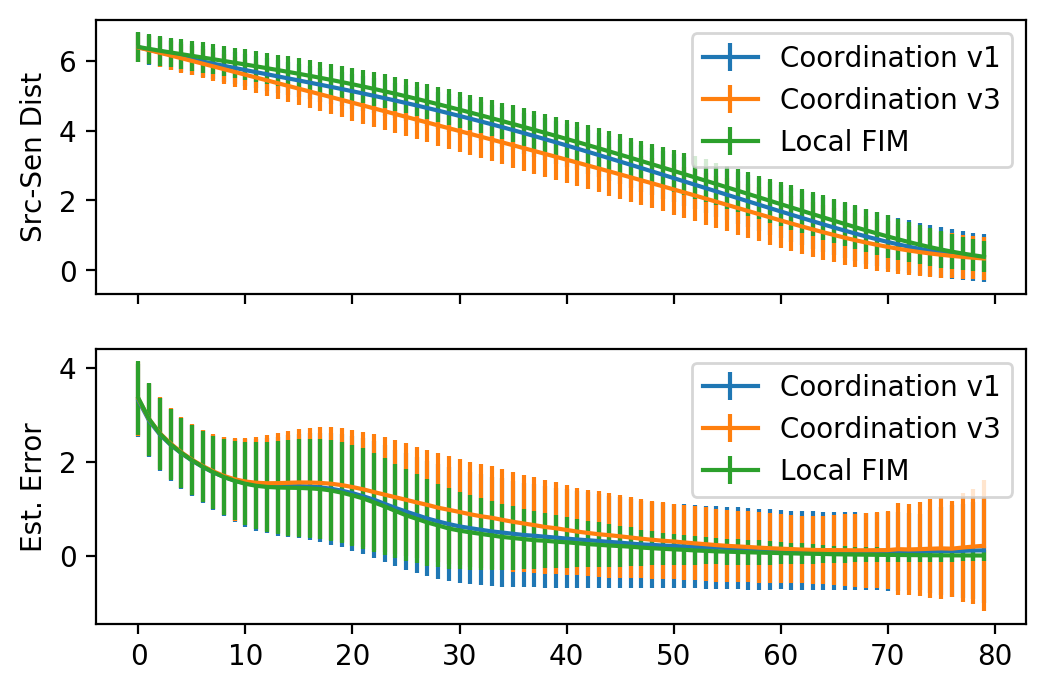

In [280]:
'''Plotting'''
fig,axes=plt.subplots(2,dpi=200,sharex=True)
for name,d in data.items():
    ps = np.array(d['p'])
    qhat = np.array(d['qhat'])
    # qhat.shape=ps.shape=(N_trails,N_iter,N_sen,space_dim)
    dist = np.linalg.norm(ps-q,axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
    axes[0].errorbar(x,ave_median_dist,yerr=std_median_dist,label= name)
    axes[0].set_ylabel('Src-Sen Dist')
    axes[0].legend()
    

    err = np.linalg.norm(qhat-q,axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    ave_median_err = np.mean(np.median(err,axis=-1),axis=0)
    std_median_err = np.std(np.median(err,axis=-1),axis=0)

    x = np.arange(N_iter)
    axes[1].errorbar(x,ave_median_err,yerr=std_median_err,label= name)
    axes[1].set_ylabel('Est. Error')
    axes[1].legend()
plt.show()